In [3]:
!python -V

Python 3.8.13


In [1]:
import pandas as pd
print(pd.__version__)

1.4.1


In [2]:
import sklearn
print(sklearn.__version__)

1.0.2


In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import missingno as msno
from collections import Counter
import nltk 
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re
from sklearn.feature_extraction.text import CountVectorizer
import sklearn.preprocessing as preprocessing
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import category_encoders as ce
import sys  #system specific parameters and names
import gc   #garbage collector interface
import yfinance as yf
from scipy.sparse import hstack, csr_matrix


## tensorflow imports
import tensorflow as tf
from tensorflow.keras import layers 
from tensorflow.keras.regularizers import l2
print(tf.__version__)

2.8.0


## Functions for memory clean up

In [3]:
def obj_size_fmt(num):
    if num<10**3:
        return "{:.2f}{}".format(num,"B")
    elif ((num>=10**3)&(num<10**6)):
        return "{:.2f}{}".format(num/(1.024*10**3),"KB")
    elif ((num>=10**6)&(num<10**9)):
        return "{:.2f}{}".format(num/(1.024*10**6),"MB")
    else:
        return "{:.2f}{}".format(num/(1.024*10**9),"GB")

def memory_usage():
    memory_usage_by_variable=pd.DataFrame({k:sys.getsizeof(v)\
    for (k,v) in globals().items()},index=['Size'])
    memory_usage_by_variable=memory_usage_by_variable.T
    memory_usage_by_variable=memory_usage_by_variable.sort_values(by='Size',ascending=False).head(10)
    memory_usage_by_variable['Size']=memory_usage_by_variable['Size'].apply(lambda x: obj_size_fmt(x))
    return memory_usage_by_variable

In [4]:
import os
# the current working directory.
currentDirectory = os.getcwd()
print(currentDirectory)

C:\Users\dey4d\CapstoneProj


In [5]:
%%time
file_in = r'C:\Users\dey4d\CapstoneProj\index_sec'
import pickle as pickle
with open(file_in, "rb") as fh:
    data2 = pickle.load(fh)

fh.close()

CPU times: total: 11.8 s
Wall time: 12.5 s


In [6]:
data2.head(2)

,CompanyCIK,CompanyName,FileType,FileDate,EdgarTextUrl,EdgarHtmlUrl,AccessionNumber,SecFileName,CompanyTicker,FileDate_ClosingPrice,FileDate_Plus_20,FileDate_Plus_20_Price,Pct_Change_20,Share_Unit_Value_Raw,FileName,f_text,file_text_length
FileDate,,,,,,,,,,,,,,,,,
2019-01-03,717954,UNIFIRST CORP,10-Q,2019-01-03,edgar/data/717954/0001284084-19-000002.txt,edgar/data/717954/0001284084-19-000002-index.html,0001284084-19-000002,2019-QTR1,UNF,133.860001,2019-01-23,136.509995,1.979676,2.649994,717954_0001284084-19-000002.txt,"[various estimate, the result, timely decision...",1870
2019-01-03,1084765,RESOURCES CONNECTION INC,10-Q,2019-01-03,edgar/data/1084765/0001193125-19-001543.txt,edgar/data/1084765/0001193125-19-001543-index....,0001193125-19-001543,2019-QTR1,RGP,13.600000,2019-01-23,16.590000,21.985292,2.990000,1084765_0001193125-19-001543.txt,"[asc topic contract term, limited number, the ...",2305


In [7]:
## get the statistics of file_text_length
data2['file_text_length'].describe()

count    45382.000000
mean      1968.146137
std       1388.282347
min         22.000000
25%       1112.000000
50%       1542.000000
75%       2318.000000
max      14139.000000
Name: file_text_length, dtype: float64

In [8]:
## taking only stocks with the filings size (file_text_length) greater than 1000
data_filing_size = data2[data2['file_text_length'] > 1000]

In [9]:
# data_filing_size.info()

In [10]:
## taking only stocks with values more than 50
data_filingsize_price = data_filing_size[data_filing_size['FileDate_ClosingPrice'] > 50]

In [11]:
data_filingsize_price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7820 entries, 2019-01-03 to 2022-04-04
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   CompanyCIK              7820 non-null   int64         
 1   CompanyName             7820 non-null   object        
 2   FileType                7820 non-null   object        
 3   FileDate                7820 non-null   datetime64[ns]
 4   EdgarTextUrl            7820 non-null   object        
 5   EdgarHtmlUrl            7820 non-null   object        
 6   AccessionNumber         7820 non-null   object        
 7   SecFileName             7820 non-null   object        
 8   CompanyTicker           7820 non-null   object        
 9   FileDate_ClosingPrice   7820 non-null   float64       
 10  FileDate_Plus_20        7820 non-null   datetime64[ns]
 11  FileDate_Plus_20_Price  7820 non-null   float64       
 12  Pct_Change_20           7820 n

In [12]:
## features besides text to be used in the model
df_non_text_features = data_filingsize_price.drop(columns = ['CompanyCIK','CompanyName','EdgarTextUrl','EdgarHtmlUrl','AccessionNumber','FileDate_Plus_20','FileDate_Plus_20_Price','Share_Unit_Value_Raw','FileName','f_text'])

In [13]:
df_non_text_features = df_non_text_features.reset_index(drop=True)
df_non_text_features.head(4)

,FileType,FileDate,SecFileName,CompanyTicker,FileDate_ClosingPrice,Pct_Change_20,file_text_length
0,10-Q,2019-01-03,2019-QTR1,UNF,133.860001,1.979676,1870
1,10-Q,2019-01-04,2019-QTR1,LW,75.580002,-5.583489,1692
2,10-Q,2019-01-08,2019-QTR1,CCF,95.870003,1.648059,2048
3,10-Q,2019-01-08,2019-QTR1,KMX,64.910004,-7.441075,2151


In [14]:
%%time
## extracting the month only from file date
df_non_text_features['FileDate']=df_non_text_features.FileDate.astype('str')

FileDate = df_non_text_features['FileDate']

File_Mon = []

for pd in FileDate:
    mon = pd[5:7]
    File_Mon.append(mon)
    
# adding the confromed period month to the dataframe
df_non_text_features["File_Mon"] = File_Mon

CPU times: total: 93.8 ms
Wall time: 89 ms


In [15]:
%%time
## extracting the QTR only from SecFileName
df_non_text_features['SecFileName']=df_non_text_features.SecFileName.astype('str')

SecFileName = df_non_text_features['SecFileName']

QTR = []

for pd in SecFileName:
    qtr = pd[5:9]
    QTR.append(qtr)
    
# adding the confromed period month to the dataframe
df_non_text_features["QTR"] = QTR

CPU times: total: 0 ns
Wall time: 8.01 ms


In [16]:
# df_non_text_features.head(3)

In [17]:
%%time
### Converting Pct_Change_20  to boolean variable based on whether the change is exceeding 5%

per_change_exceeding = []

for index, row in df_non_text_features.iterrows():
    if row['Pct_Change_20'] > 5:     
          per_change_exceeding.append("True")
    else: 
        per_change_exceeding.append("False")
        
df_non_text_features["per_change_exceeding"] = per_change_exceeding

CPU times: total: 281 ms
Wall time: 270 ms


In [19]:
np.unique(per_change_exceeding)

array(['False', 'True'], dtype='<U5')

In [20]:
df_non_text_features.head(3)

,FileType,FileDate,SecFileName,CompanyTicker,FileDate_ClosingPrice,Pct_Change_20,file_text_length,File_Mon,QTR,per_change_exceeding
0,10-Q,2019-01-03,2019-QTR1,UNF,133.860001,1.979676,1870,01,QTR1,False
1,10-Q,2019-01-04,2019-QTR1,LW,75.580002,-5.583489,1692,01,QTR1,False
2,10-Q,2019-01-08,2019-QTR1,CCF,95.870003,1.648059,2048,01,QTR1,False


In [21]:
### Droping filedate, Secfilename and Pct_Change_20 from the dataframe
df_non_text_features = df_non_text_features.drop(columns = ['FileDate','SecFileName', 'Pct_Change_20'])

In [22]:
# %%time
# ## adding sector based on tickers
# import yfinance as yf

# tickers = df_non_text_features['CompanyTicker']
# Sector = []

# for ticker in tickers: 
#     try:
#         sector = yf.Ticker(ticker).info['sector']       
#     except:
#         sector =" "
#         print(sys.exc_info()[0], "occurred.")     
#     Sector.append(sector) 

# print(len(Sector))
# print(set(Sector))

In [23]:
# from collections import Counter
# len(Sector)
# print(set(Sector))
# Counter(Sector).keys()

In [24]:
# values, counts = np.unique(Sector, return_counts=True)
# print(values, ' ', counts)

In [25]:
df_non_text_features.head(3)

,FileType,CompanyTicker,FileDate_ClosingPrice,file_text_length,File_Mon,QTR,per_change_exceeding
0,10-Q,UNF,133.860001,1870,01,QTR1,False
1,10-Q,LW,75.580002,1692,01,QTR1,False
2,10-Q,CCF,95.870003,2048,01,QTR1,False


In [28]:
%%time
## tf-idf vectorizer for ngram text

import pandas as pd

MAX_FEATURES = 20000 

def dummy_fun(doc):
    return doc

tfidvec = TfidfVectorizer(analyzer='word', 
                          tokenizer=dummy_fun,                      
                          preprocessor=dummy_fun,
                          token_pattern=None,
#                           max_features = MAX_FEATURES,
                          binary=True, 
                          smooth_idf=False,
                          max_df=0.80,     
                          min_df=0.005,       
                          norm= 'l1',      ## increase the sparsity
                          stop_words= None,
                          strip_accents=None,
                          use_idf=True,
                          sublinear_tf=True)

df_tfidvec = tfidvec.fit_transform(data_filingsize_price["f_text"])

dfsp_tfidf = pd.DataFrame(df_tfidvec.toarray(), columns=tfidvec.get_feature_names_out())
print(dfsp_tfidf.head(3))
print('='*100)
print('Size of the tfidf Vector Matrix: ', dfsp_tfidf.shape)

   000s  101in  10b  10b18  10b51 plan  10b51 trading plan  10e       10k  \
0   0.0    0.0  0.0    0.0         0.0                 0.0  0.0  0.000000   
1   0.0    0.0  0.0    0.0         0.0                 0.0  0.0  0.000832   
2   0.0    0.0  0.0    0.0         0.0                 0.0  0.0  0.000000   

   10k 10q       10q  ...  yousc section  yousc section certification  \
0      0.0  0.000000  ...       0.000417                          0.0   
1      0.0  0.000418  ...       0.000000                          0.0   
2      0.0  0.000356  ...       0.000000                          0.0   

   yousmanage banking office  youtube  ytd  zero percent  zero share  \
0                        0.0      0.0  0.0           0.0         0.0   
1                        0.0      0.0  0.0           0.0         0.0   
2                        0.0      0.0  0.0           0.0         0.0   

   zip code  zone restriction  zoning  
0       0.0               0.0     0.0  
1       0.0               0.0

In [29]:
# df_tfidvec

In [30]:
##  final data frame 
import pandas as pd
df_final = pd.concat([df_non_text_features, dfsp_tfidf], axis=1, join='inner')

In [31]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7820 entries, 0 to 7819
Columns: 43520 entries, FileType to zoning
dtypes: float64(43514), int64(1), object(5)
memory usage: 2.5+ GB


In [32]:
%%time
import pandas as pd
categorical_columns = ['FileType','CompanyTicker','File_Mon','QTR']

for column in categorical_columns:
#     print(column, ' ', df_final_2.dtypes[column])
    tempdf = pd.get_dummies(df_final[column], prefix=column)
    df_final = pd.merge(
        left=df_final,
        right=tempdf,
        left_index=True,
        right_index=True,
    )
    df_final = df_final.drop(columns=column)

CPU times: total: 37.1 s
Wall time: 37.5 s


In [43]:
%%time
df_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7820 entries, 0 to 7819
Columns: 45023 entries, FileDate_ClosingPrice to QTR_QTR4
dtypes: float64(43514), int64(1), object(1), uint8(1507)
memory usage: 2.5+ GB
CPU times: total: 11.5 s
Wall time: 16.9 s


In [36]:
%%time
# del data2
# del data_filing_size
# del dfsp_tfidf

gc.collect()
memory_usage()

CPU times: total: 1.97 s
Wall time: 1.97 s


,Size
df_final,2.67GB
data_filingsize_price,161.51MB
df_non_text_features,2.44MB
FileDate,511.80KB
SecFileName,504.16KB
per_change_exceeding,67.53KB
QTR,67.53KB
File_Mon,67.53KB
_6,38.27KB
tempdf,30.69KB


In [32]:
# %%time
# from scipy import sparse
# df_final_comp = csr_matrix(df_final.astype(np.float))

In [37]:
## ploting the distribution of response variable 
missbeat_plot = sns.catplot(x="per_change_exceeding", kind="count",data=df_final,height=5, aspect=.5)
missbeat_plot.fig.suptitle("'per_change_exceeding' Distribution",
                  fontsize=15, fontdict={"weight": "bold"})
'''Though not perfect, it is not unbalanced '''

In [38]:
### QR factorization to find the orthogonal columns to have a better conditioned matrix

## DROP the response variable 

df_final_explantory = df_final.drop(columns = ['per_change_exceeding'])



In [26]:
# %%time
# from scipy import sparse
# df_final_explantory_comp = csr_matrix(df_final_explantory.astype(np.float))

In [27]:
# print("Memory utilised (bytes): ", sys.getsizeof(df_final_explantory_comp))

In [30]:
%%time
print('matrix condition:  ', np.linalg.cond(df_final_explantory, p=None))

'''it is an ill-conditioned matrix as the condition value is more than 2^16; so we need to use orthogonal bases'''

matrix condition:   1.2593810138696542e+21


## Using SVD decomposition

In [31]:
# ## SVD
# from numpy import dot, diag, exp, real, sin, cosh, tanh
# from scipy.linalg import svd, svdvals

In [32]:
# def omega_approx(beta):
#     """Return an approximate omega value for given beta. Equation (5) from Gavish 2014."""
#     return 0.56 * beta**3 - 0.95 * beta**2 + 1.82 * beta + 1.43

# df_final_explantory = df_final.drop(columns = ['per_change_exceeding'])

# # do SVD and find tau star hat
# U,sv,Vh = svd(df_final_explantory, False, lapack_driver='gesvd')
# beta = min(df_final_explantory.shape) / max(df_final_explantory.shape)
# tau = np.median(sv) * omega_approx(beta)

In [33]:
# rank = round(tau) + 1
# print('Optimal Cutoff Ranks, after adjustment for rounding, for SVD as per Gavish and Donoho : ', rank) 

In [34]:
# ### top 7 column bases represent most of the variation
# percentage_of_variation = round((sum(np.diagonal(np.diag(sv[:7]))) / sum(np.diagonal(np.diag(sv))))*100 , 2)

# print('percentage of variation represented by 7 column bases :', percentage_of_variation)

In [35]:
# ## taking top columns to create lower dimension matrix
# df_lower = U[:,:7] 
# print('Size of the lower dimension matrix---')
# print(df_lower.shape)

In [36]:
# ## weighting the column bases with the inverse of variation
# # np.diag(sv[:7])
# df_lower_new = U[:,:7] @ np.linalg.inv(np.diag(sv[:7]))
# print('Size of the new lower dimension matrix---')
# print(df_lower_new.shape)

In [37]:
# df_response = pd.DataFrame(per_change_exceeding, columns =['per_change_exceeding'])
# df_response["per_change_exceeding"] = (df_response["per_change_exceeding"] == "True").astype(int)

# print(df_response['per_change_exceeding'].value_counts())

In [38]:
# # y = df_final['per_change_exceeding']  ## this is explanatory variable

# y = np.array(df_response) ## already seperated from the data and stored in the y variable. converting to array
# X = df_lower_new
# print('Size of target vector: ', y.shape)
# print('='*50)
# print('Size of explanatory matrix: ',X.shape)

In [39]:
# ## Since the data is somewhat unbalanced, I prefer to use StratifiedKFold
# from sklearn.model_selection import StratifiedKFold

# cv = StratifiedKFold(n_splits= 5,shuffle=True,random_state=42)

# for train, test in cv.split(X,y):
#     X_train = X[train] 
#     X_test  = X[test] 
#     y_train = y[train]
#     y_test  = y[test] 
    
# print('Size of training data: ', len(X_train), 'and its shape : ', X_train.shape)
# print('Size of training labels: ', len(y_train), 'and its shape : ', y_train.shape)
# print('Size of test data: ', len(X_test), 'and its shape : ', X_test.shape)
# print('Size of test labels: ', len(y_test), 'and its shape : ', y_test.shape)

## Dense Network

In [40]:
# # defining the architecture of this connected neural network

# def build_fc_model():    
#     '''defining the model using the Sequential class'''
#     fc_model = tf.keras.Sequential([
#       # First define a input layer
#       tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),

#       # Defining the activation function for the first fully connected (Dense) layer      
#       tf.keras.layers.Dense(100, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        
#       # Defining the activation function for the second fully connected (Dense) layer      
#       tf.keras.layers.Dense(100, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.01)),     

#       # Defining the activation function for the third fully connected (Dense) layer      
#       tf.keras.layers.Dense(100, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.01)),   
        
#       # Defining the second Dense layer to output the classification probabilities
#       tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, activity_regularizer=tf.keras.regularizers.L2(0.01))       
#     ])
#     return fc_model

# model = build_fc_model()
# model.summary()

In [41]:
# ## Using Adam optimizer with a learning rate of 0.01
# ## since it is categorical classification, we are opting for caterorical_crossentropy for sparse data
# ## chosing the matrix as accuracy

# learning_rate = 0.0001

# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

In [42]:
# # Defining the batch size and the number of epochs to use during training
# BATCH_SIZE = 32
# EPOCHS = 5

# model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

## Using QR decomposition 

In [113]:
%%time
# del df_final
# del df_non_text_features
# del SecFileName
# del FileDate
# del QTR
# del tempdf
# del File_Mon

gc.collect()
memory_usage()

CPU times: total: 19.9 s
Wall time: 5min 4s


,Size
df_final,1.89GB
df_final_explantory,1.89GB
r,1.33GB
X_train_img,255.70MB
df_final_col_bases,130.77MB
df_q_col_bases,130.75MB
X,130.75MB
q,130.75MB
X_train,104.61MB
X_test_img,63.91MB


In [28]:
# %%time
# ## converting datatype from float64 to float32 to reduce the size of the matrix
# for col in df_final_explantory.columns:
#     if df_final_explantory[col].dtype == 'float64':
#         df_final_explantory[col] = df_final_explantory[col].astype('float32') 

In [29]:
# %%time
# df_final_explantory.info()

In [39]:
%%time
### QR factorization to find the orthogonal columns to have a better conditioned matrix

# df_final_explantory = df_final.drop(columns = ['per_change_exceeding'])
matrix = df_final_explantory.to_numpy()

CPU times: total: 4.3 s
Wall time: 4.5 s


In [41]:
%%time
del df_final_explantory

gc.collect()
memory_usage()

CPU times: total: 1.94 s
Wall time: 1.92 s


,Size
df_final,2.67GB
data_filingsize_price,161.51MB
df_non_text_features,2.44MB
FileDate,511.80KB
SecFileName,504.16KB
File_Mon,67.53KB
per_change_exceeding,67.53KB
QTR,67.53KB
_6,38.27KB
tempdf,30.69KB


In [42]:
%%time
## qr factorization 
q, r = np.linalg.qr(matrix)

CPU times: total: 5min 54s
Wall time: 1min 43s


In [43]:
matrix.shape

(7820, 45022)

In [44]:
q.shape

(7820, 7820)

In [45]:
r.shape

(7820, 45022)

In [46]:
%%time
### putting the column bases (q) into dataframe

column_bases = [f'col_{num}' for num in range(len(np.transpose(q)))]

df_q_col_bases = pd.DataFrame(q, columns=column_bases)

df_q_col_bases.head(3)

CPU times: total: 15.6 ms
Wall time: 68.5 ms


,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,col_9,...,col_7810,col_7811,col_7812,col_7813,col_7814,col_7815,col_7816,col_7817,col_7818,col_7819
0,-0.000126,-0.007863,-0.000528,-0.000398,-0.001002,-0.000316,-0.000826,-0.000761,-0.000347,-0.002086,...,-1.754513e-16,1.283718e-16,7.447396e-17,-2.471724e-18,-3.382243e-16,-1.252103e-17,-1.381784e-16,-3.154973e-17,7.293513e-18,-3.412533e-18
1,-0.000071,-0.007116,-0.000478,-0.000360,-0.000907,-0.000286,-0.000747,-0.000689,-0.000314,0.024632,...,3.306694e-16,-1.651550e-17,-5.210623e-16,-5.128195e-16,2.114526e-16,4.299818e-17,-1.119074e-16,-1.850420e-16,2.167929e-16,-1.839293e-17
2,-0.000090,-0.008613,-0.000578,-0.000436,-0.001098,-0.000346,-0.000904,-0.000834,-0.000380,-0.002280,...,-3.410376e-16,4.615214e-17,4.514945e-16,6.310789e-16,8.856483e-17,-4.269309e-16,1.740894e-15,1.582384e-16,-4.446505e-16,-1.164409e-16


In [47]:
## new dataframe with response variable

df_response = pd.DataFrame(per_change_exceeding, columns =['per_change_exceeding'])
df_response["per_change_exceeding"] = (df_response["per_change_exceeding"] == "True").astype(int)

df_final_col_bases = pd.concat([df_response, df_q_col_bases], axis=1, join='inner')
df_final_col_bases.head(3)    

,per_change_exceeding,col_0,col_1,col_2,col_3,col_4,col_5,col_6,col_7,col_8,...,col_7810,col_7811,col_7812,col_7813,col_7814,col_7815,col_7816,col_7817,col_7818,col_7819
0,0,-0.000126,-0.007863,-0.000528,-0.000398,-0.001002,-0.000316,-0.000826,-0.000761,-0.000347,...,-1.754513e-16,1.283718e-16,7.447396e-17,-2.471724e-18,-3.382243e-16,-1.252103e-17,-1.381784e-16,-3.154973e-17,7.293513e-18,-3.412533e-18
1,0,-0.000071,-0.007116,-0.000478,-0.000360,-0.000907,-0.000286,-0.000747,-0.000689,-0.000314,...,3.306694e-16,-1.651550e-17,-5.210623e-16,-5.128195e-16,2.114526e-16,4.299818e-17,-1.119074e-16,-1.850420e-16,2.167929e-16,-1.839293e-17
2,0,-0.000090,-0.008613,-0.000578,-0.000436,-0.001098,-0.000346,-0.000904,-0.000834,-0.000380,...,-3.410376e-16,4.615214e-17,4.514945e-16,6.310789e-16,8.856483e-17,-4.269309e-16,1.740894e-15,1.582384e-16,-4.446505e-16,-1.164409e-16


In [48]:
df_response['per_change_exceeding'].value_counts()

0    5967
1    1853
Name: per_change_exceeding, dtype: int64

In [49]:
# %%time
# del df_q_col_bases
# del r
# del q

# gc.collect()
# memory_usage()

In [50]:
## X for explanatory variables and y for the response variable
## Normalize explanatory variables 
y = df_final_col_bases['per_change_exceeding']
X = df_final_col_bases.drop('per_change_exceeding', axis=1)

# from sklearn.preprocessing import Normalizer
# X = Normalizer().fit(X_raw)
print('Size of target vector: ', y.shape)
print('='*50)
print('Size of explanatory matrix: ',X.shape)

Size of target vector:  (7820,)
Size of explanatory matrix:  (7820, 7820)


In [51]:
%%time
# del df_final_col_bases

# gc.collect()
# memory_usage()

CPU times: total: 0 ns
Wall time: 0 ns


In [52]:
## Spliting data using stratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold

cross_val = StratifiedKFold(n_splits=15,shuffle=True,random_state=42)

for train, test in cross_val.split(X,y):
    X_train = X.iloc[train]
    X_test  = X.iloc[test]
    y_train = y.iloc[train]
    y_test  = y.iloc[test] 

print('Size of training data: ', len(X_train), 'and its shape : ', X_train.shape)
print('Size of training labels: ', len(y_train), 'and its shape : ', y_train.shape)
print('Size of test data: ', len(X_test), 'and its shape : ', X_test.shape)
print('Size of test labels: ', len(y_test), 'and its shape : ', y_test.shape)

Size of training data:  7299 and its shape :  (7299, 7820)
Size of training labels:  7299 and its shape :  (7299,)
Size of test data:  521 and its shape :  (521, 7820)
Size of test labels:  521 and its shape :  (521,)


In [53]:
%%time
# del X

# gc.collect()
# memory_usage()

CPU times: total: 0 ns
Wall time: 0 ns


In [54]:
# Normalize all of the explanatory features with StandardScaler in train and test sets
from sklearn.preprocessing import StandardScaler
X_train = StandardScaler().fit_transform(X_train)
X_test = StandardScaler().fit_transform(X_test)

In [55]:
y_train.unique()

array([0, 1])

## Dense Network

In [86]:
# defining the architecture of this connected neural network

def build_fc_model():    
    '''defining the model using the Sequential class'''
    fc_model = tf.keras.Sequential([
      # First define a input layer
      tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),

      # Defining the activation function for the first fully connected (Dense) layer      
      tf.keras.layers.Dense(500, activation=tf.nn.relu,  kernel_initializer = "HeNormal", use_bias = True, 
                           bias_initializer='HeNormal', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        
      # Normalizing the batch to prevent from exploding  
      tf.keras.layers.BatchNormalization(),        
        
      # Adding dropout to prevent from overfitting
      tf.keras.layers.Dropout(0.5),    
        
      # Defining the activation function for the second fully connected (Dense) layer      
      tf.keras.layers.Dense(1000, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.01)),   

      # adding dropout to prevent from overfitting 
      tf.keras.layers.Dropout(0.5),      
        
      # Defining the activation function for the third fully connected (Dense) layer      
      tf.keras.layers.Dense(500, activation=tf.nn.relu, kernel_regularizer=tf.keras.regularizers.L2(0.01)), 
        
      # Normalizing the batch to prevent from exploding        
      tf.keras.layers.BatchNormalization(),           
        
      # Defining the second Dense layer to output the classification probabilities
      tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, activity_regularizer=tf.keras.regularizers.L2(0.01))       
    ])
    return fc_model

model = build_fc_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 500)               3910500   
                                                                 
 batch_normalization_4 (Batc  (None, 500)              2000      
 hNormalization)                                                 
                                                                 
 dropout_4 (Dropout)         (None, 500)               0         
                                                                 
 dense_8 (Dense)             (None, 1000)              501000    
                                                                 
 dropout_5 (Dropout)         (None, 1000)              0         
                                                                 
 dense_9 (Dense)             (None, 500)               500500    
                                                      

In [87]:
## Using Adam optimizer with a learning rate of 0.01
## since it is categorical classification, we are opting for caterorical_crossentropy for sparse data
## chosing the matrix as accuracy

learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [88]:
# Defining the batch size and the number of epochs to use during training
BATCH_SIZE = 32
EPOCHS = 10

model.fit(X_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/10
229/229 [==============================] - 10s 42ms/step - loss: 22.1408 - accuracy: 0.5540
Epoch 2/10
229/229 [==============================] - 10s 42ms/step - loss: 18.6975 - accuracy: 0.6672
Epoch 3/10
229/229 [==============================] - 10s 42ms/step - loss: 15.9208 - accuracy: 0.7412
Epoch 4/10
229/229 [==============================] - 10s 43ms/step - loss: 13.5608 - accuracy: 0.8190
Epoch 5/10
229/229 [==============================] - 10s 46ms/step - loss: 11.4939 - accuracy: 0.9081
Epoch 6/10
229/229 [==============================] - 11s 48ms/step - loss: 9.7192 - accuracy: 0.9468
Epoch 7/10
229/229 [==============================] - 11s 47ms/step - loss: 8.1669 - accuracy: 0.9671
Epoch 8/10
229/229 [==============================] - 11s 48ms/step - loss: 6.8074 - accuracy: 0.9751
Epoch 9/10
229/229 [==============================] - 11s 48ms/step - loss: 5.6541 - accuracy: 0.9818
Epoch 10/10
229/229 [==============================] - 12s 51ms/step - loss: 

In [89]:
## Evaluating the model with the test data

test_loss, test_acc = model.evaluate(X_test, y_test) 

print('Test loss:', test_loss)
print('----------------------------')
print('Test accuracy:', test_acc)


17/17 [==============================] - 0s 14ms/step - loss: 5.4832 - accuracy: 0.7582
Test loss: 5.483181953430176
----------------------------
Test accuracy: 0.7581573724746704


In [2]:
## Changing the threshold for prediction 

prediction = model.predict(X_test) ## prediction probabilities

actual_pred = []
prediction_threshold = 0.5

for p in prediction: 
    if p > prediction_threshold: 
        pred = 1
        actual_pred.append(pred)
    else: 
        pred = 0
        actual_pred.append(pred)

In [ ]:
print('-----------------------Confusion Report----------------------')
target_names = ['Yes', 'No']
print(classification_report(y_test, actual_pred,  target_names=target_names))

## Converting images

In [60]:
## shape of the matrix
df_q_col_bases.shape

(7820, 7820)

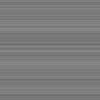

In [62]:
## Converting images from the data row
from PIL import Image 
images = df_q_col_bases.apply(lambda x: Image.fromarray(x.values.reshape(7820,1), 'L').resize((100, 100)), axis=1)

# show image 0
images[0]

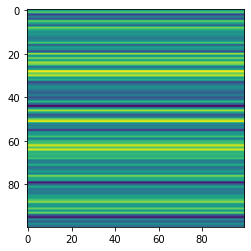

In [67]:
import matplotlib.pyplot as plt
image = images[0]
plt.imshow(image)
plt.show()

In [68]:
# images_arr = np.array(images)
## converting images (png) to tensor

imagetensor = []

for i in range(len(images)): 
    image_tensor = tf.convert_to_tensor(images[i])
    imagetensor.append(image_tensor)

In [69]:
imagetensor[20]

<tf.Tensor: shape=(100, 100), dtype=uint8, numpy=
array([[132, 132, 132, ..., 132, 132, 132],
       [133, 133, 133, ..., 133, 133, 133],
       [130, 130, 130, ..., 130, 130, 130],
       ...,
       [120, 120, 120, ..., 120, 120, 120],
       [119, 119, 119, ..., 119, 119, 119],
       [126, 126, 126, ..., 126, 126, 126]], dtype=uint8)>

In [70]:
image_arr = np.array(imagetensor)

In [71]:
image_arr[20]

array([[132, 132, 132, ..., 132, 132, 132],
       [133, 133, 133, ..., 133, 133, 133],
       [130, 130, 130, ..., 130, 130, 130],
       ...,
       [120, 120, 120, ..., 120, 120, 120],
       [119, 119, 119, ..., 119, 119, 119],
       [126, 126, 126, ..., 126, 126, 126]], dtype=uint8)

In [72]:
## finding training and testing impages
X_train_img = image_arr[train]
X_test_img = image_arr[test]

In [73]:
X_train_img[20]

array([[141, 141, 141, ..., 141, 141, 141],
       [137, 137, 137, ..., 137, 137, 137],
       [140, 140, 140, ..., 140, 140, 140],
       ...,
       [134, 134, 134, ..., 134, 134, 134],
       [124, 124, 124, ..., 124, 124, 124],
       [126, 126, 126, ..., 126, 126, 126]], dtype=uint8)

### CNN 

In [74]:
X_train_img = X_train_img / 255
X_test_img = X_test_img / 255

In [75]:
X_train_img[20]

array([[0.55294118, 0.55294118, 0.55294118, ..., 0.55294118, 0.55294118,
        0.55294118],
       [0.5372549 , 0.5372549 , 0.5372549 , ..., 0.5372549 , 0.5372549 ,
        0.5372549 ],
       [0.54901961, 0.54901961, 0.54901961, ..., 0.54901961, 0.54901961,
        0.54901961],
       ...,
       [0.5254902 , 0.5254902 , 0.5254902 , ..., 0.5254902 , 0.5254902 ,
        0.5254902 ],
       [0.48627451, 0.48627451, 0.48627451, ..., 0.48627451, 0.48627451,
        0.48627451],
       [0.49411765, 0.49411765, 0.49411765, ..., 0.49411765, 0.49411765,
        0.49411765]])

In [76]:
X_train_img.shape

(7299, 100, 100)

In [77]:
## CNN architecture 
model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(100, (5,5), padding='same', kernel_initializer = "HeNormal", use_bias = True, 
                           bias_initializer='HeNormal', activation="relu",input_shape=(100, 100, 1)),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),

    tf.keras.layers.Conv2D(100, (5,5), padding='same',activation="relu"),
    tf.keras.layers.MaxPooling2D((3, 3), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1, activation="softmax")
]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 100)     2600      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 49, 49, 100)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 49, 49, 100)       250100    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 24, 24, 100)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 57600)             0         
                                                                 
 dense_4 (Dense)             (None, 100)              

In [78]:
## Using Adam optimizer with a learning rate of 0.01
## since it is categorical classification, we are opting for caterorical_crossentropy for sparse data
## chosing the matrix as accuracy

learning_rate = 0.0001

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), 
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [79]:
# Defining the batch size and the number of epochs to use during training
BATCH_SIZE = 32
EPOCHS = 5

model.fit(X_train_img, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS)

Epoch 1/5
229/229 [==============================] - 425s 2s/step - loss: 0.8037 - accuracy: 0.2369
Epoch 2/5
229/229 [==============================] - 493s 2s/step - loss: 0.7015 - accuracy: 0.2369
Epoch 3/5
229/229 [==============================] - 491s 2s/step - loss: 0.6634 - accuracy: 0.2369
Epoch 4/5
229/229 [==============================] - 493s 2s/step - loss: 0.6352 - accuracy: 0.2369
Epoch 5/5
229/229 [==============================] - 490s 2s/step - loss: 0.6138 - accuracy: 0.2369


In [80]:
## Evaluating the model with the test data

test_loss, test_acc = model.evaluate(X_test_img, y_test) 

print('Test loss:', test_loss)
print('----------------------------')
print('Test accuracy:', test_acc)

17/17 [==============================] - 8s 482ms/step - loss: 0.5514 - accuracy: 0.2380
Test loss: 0.551430344581604
----------------------------
Test accuracy: 0.23800383508205414


## Random Forest

In [59]:
## grid parameters
from pprint import pprint
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 300, num = 4)]
max_depth = [int(x) for x in np.linspace(10, 20, num = 3)]
max_depth.append(None)
min_samples_split = [5, 10, 15]
min_samples_leaf = [5, 10, 15]
max_leaf_nodes = [5, 10,15]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf, 
               'max_leaf_nodes' : max_leaf_nodes}
pprint(random_grid)

{'max_depth': [10, 15, 20, None],
 'max_leaf_nodes': [5, 10, 15],
 'min_samples_leaf': [5, 10, 15],
 'min_samples_split': [5, 10, 15],
 'n_estimators': [50, 133, 216, 300]}


In [62]:
# %%time
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.ensemble import RandomForestClassifier

# # Use the random grid to search for best hyperparameters
# clf_rf = RandomForestClassifier()

# rf_random = RandomizedSearchCV(estimator = clf_rf, param_distributions = random_grid, n_iter = 250,  cv = None, scoring = 'accuracy',  verbose=2, random_state=21, n_jobs = -1)
# # Fit the random search model
# rf_random.fit(X_train, y_train)
# pprint(rf_random.best_params_)

In [82]:
%%time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import  accuracy_score

rf_clf = RandomForestClassifier(n_jobs=-1, n_estimators=500, 
                                random_state=42)
rf_clf.fit(X_train, y_train)
## Model evaluation 
predictions = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test, predictions)
print('-------------Model Performance----------------')   
print('Accuracy = {:0.2%}.'.format(accuracy))

print('-----------------------Confusion Report----------------------')
target_names = ['Yes', 'No']
print(classification_report(y_test, predictions,  target_names=target_names))

-------------Model Performance----------------
Accuracy = 76.20%.
-----------------------Confusion Report----------------------
              precision    recall  f1-score   support

         Yes       0.76      1.00      0.86       397
          No       0.00      0.00      0.00       124

    accuracy                           0.76       521
   macro avg       0.38      0.50      0.43       521
weighted avg       0.58      0.76      0.66       521

CPU times: total: 20min 57s
Wall time: 2min 44s


## XG Boost

In [64]:
# !pip install xgboost
from xgboost import XGBClassifier

In [65]:
%%time
best_xgb = XGBClassifier(n_jobs=-1, 
#                             gamma= 2,
                            learning_rate=0.2, 
                            n_estimators=500,
#                             colsample_bytree=0.5,
                            max_depth=12, 
#                             min_child_weight=0.5, 
#                             subsample=0.4,
#                             objective='binary:logistic',
#                             booster = 'dart',           
#                             sample_type = 'weighted',
#                             normalize_type = 'forest',
#                             rate_drop = 0.15,
#                             skip_drop = 0.6,
                            random_state=42)

best_xgb.fit(X_train, y_train)

CPU times: total: 3h 39min 48s
Wall time: 29min 33s


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.2, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=12, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=500,
              n_jobs=-1, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [81]:
%%time
## Model evaluation 
yhat_xgb = best_xgb.predict(X_test) ## prediction 
accuracy = accuracy_score(y_test, yhat_xgb)

print('-------------Model Performance----------------')   
print('Accuracy = {:0.2%}'.format(accuracy))


from sklearn.metrics import classification_report

print('-----------------------Confusion Report----------------------')
target_names = ['Yes', 'No']
print(classification_report(y_test, yhat_xgb,  target_names=target_names))

-------------Model Performance----------------
Accuracy = 76.58%
-----------------------Confusion Report----------------------
              precision    recall  f1-score   support

         Yes       0.76      1.00      0.87       397
          No       1.00      0.02      0.03       124

    accuracy                           0.77       521
   macro avg       0.88      0.51      0.45       521
weighted avg       0.82      0.77      0.67       521

CPU times: total: 1.22 s
Wall time: 175 ms
